# BT 5153: Team Loren Ipsum - Image tagging system: Electronics Category only

## Reading Datasets and importing library
* The merged data file uploaded here is a 220 MB file which was created from the original datasets downloaded from this link: https://nijianmo.github.io/amazon/index.html
* This merged file was created using 2 files downloaded from the above link: 1. The review file, which contains the review data of a product and 2. The product metadata file, which contains information about the product
    * The review file has been chosen to incorporate "realism" into our dataset. Images from review file are images that we expect from users to be uploaded onto a C2C second-hand marketplace portal

In [1]:
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re #for splitting tags
import urllib #Extracting images from url's
import cv2   #For image processing
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss
from multiprocessing.pool import Pool
import gc

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
#from google.colab import drive
#drive.mount('/content/drive')

/kaggle/input/bt5153-mergeddata/mergeddata.csv


In [2]:
df = pd.read_csv('/kaggle/input/bt5153-mergeddata/mergeddata.csv')

In [3]:
#print(df)
print(len(df))
print(df.head)

112066
<bound method NDFrame.head of               asin                                      review_images  \
0       0511189877  ['https://images-na.ssl-images-amazon.com/imag...   
1       0972683275  ['https://images-na.ssl-images-amazon.com/imag...   
2       0972683275  ['https://images-na.ssl-images-amazon.com/imag...   
3       0972683275  ['https://images-na.ssl-images-amazon.com/imag...   
4       0972683275  ['https://images-na.ssl-images-amazon.com/imag...   
...            ...                                                ...   
112061  B01HICMC3A  ['https://images-na.ssl-images-amazon.com/imag...   
112062  B01HICMC3A  ['https://images-na.ssl-images-amazon.com/imag...   
112063  B01HIS365W  ['https://images-na.ssl-images-amazon.com/imag...   
112064  B01HIW2XPM  ['https://images-na.ssl-images-amazon.com/imag...   
112065  B01HIYOC0E  ['https://images-na.ssl-images-amazon.com/imag...   

                                                 category  \
0       ['Electronics', '

## Generating and Keeping only relevant tags (using Count Vectoriser)
* We use the "category" column of the dataset above to generate tags. Tags which appear atleast 0.5% of the times across entire dataset 

In [4]:
# Data might have duplicate rows due to multiple images - creating a category dataset with unique product and category

df_cat = df[['asin','category']]
df_cat.drop_duplicates(inplace = True)
#df_cat.reset_index()
df_cat.head()

print("Unique products with their categories are:", len(df_cat))
print(df_cat)

Unique products with their categories are: 39965
              asin                                           category
0       0511189877  ['Electronics', 'Accessories & Supplies', 'Aud...
1       0972683275  ['Electronics', 'Accessories & Supplies', 'Aud...
8       106171327X  ['Electronics', 'Computers & Accessories', 'Co...
10      140053271X  ['Electronics', 'eBook Readers & Accessories',...
11      1400501466  ['Electronics', 'Computers & Accessories', 'Co...
...            ...                                                ...
112060  B01HI9ZK8M  ['Electronics', 'Accessories & Supplies', 'Aud...
112061  B01HICMC3A  ['Electronics', 'Computers & Accessories', 'Ne...
112063  B01HIS365W  ['Electronics', 'Computers & Accessories', 'Co...
112064  B01HIW2XPM  ['Electronics', 'Computers & Accessories', 'Co...
112065  B01HIYOC0E  ['Electronics', 'Accessories & Supplies', 'Cor...

[39965 rows x 2 columns]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [5]:
def my_tokenizer(s):
    #s = s.replace(', ',',') # So that blank does NOT become an encoding
    s = re.split(', ',s) #Seperate tags after each comma
    #s = s.split('/&') #Seperate tags after each &
    return s

# Replace initial and starting and '\'' characters
df_cat['category'] = df_cat['category'].apply(lambda x: x.replace('[','').replace(']','').replace('\'',''))

# Implementing vectoriser - without any 
vec = CountVectorizer(tokenizer = my_tokenizer, 
                      lowercase = True,
                      min_df = 0.05, # Should appear as a tag in atleast 5% of all products
                      max_features = 100,  # a maximum of top 250 tags after the above exclusion will be considered,
                      stop_words = ['electronics'] #THIS STOP-WORD WOULD NOT BE USED ONCE EXPANDING ONTO OTHER CATEGORIES
                     )
X = vec.fit_transform(df_cat['category'])
tags = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

# Some tags are repeating causing vectoriser > 1 --> they are being replaced by 1
tags.mask(tags > 1, 1, inplace = True)

print(tags.head())
print("~2100 individual tags are now reduced to: ",tags.shape)
                   
## Joining tags to df_cat
df_vectoriser = pd.concat([df_cat.reset_index(drop=True),tags.reset_index(drop=True)], axis = 1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


   accessories  accessories & supplies  audio & video accessories  bags  \
0            0                       1                          1     0   
1            0                       1                          1     0   
2            0                       0                          0     0   
3            0                       0                          0     0   
4            0                       0                          0     0   

   cables & interconnects  camera & photo  cases & sleeves  \
0                       0               0                0   
1                       0               0                0   
2                       0               0                0   
3                       0               0                0   
4                       0               0                0   

   computer accessories & peripherals  computer components  \
0                                   0                    0   
1                                   0               

In [6]:
## Viewing concat dataset
df_vectoriser

,asin,category,accessories,accessories & supplies,audio & video accessories,bags,cables & interconnects,camera & photo,cases & sleeves,computer accessories & peripherals,computer components,computers & accessories,headphones,laptop accessories,portable audio & video,tablet accessories
0,0511189877,"Electronics, Accessories & Supplies, Audio & V...",0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,0972683275,"Electronics, Accessories & Supplies, Audio & V...",0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,106171327X,"Electronics, Computers & Accessories, Computer...",0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,140053271X,"Electronics, eBook Readers & Accessories, eBoo...",0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1400501466,"Electronics, Computers & Accessories, Computer...",0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39960,B01HI9ZK8M,"Electronics, Accessories & Supplies, Audio & V...",0,1,1,0,0,0,0,0,0,0,0,0,0,0
39961,B01HICMC3A,"Electronics, Computers & Accessories, Networki...",0,0,0,0,0,0,0,0,0,1,0,0,0,0
39962,B01HIS365W,"Electronics, Computers & Accessories, Computer...",0,0,0,0,0,0,0,1,0,1,0,0,0,0
39963,B01HIW2XPM,"Electronics, Computers & Accessories, Computer...",0,0,0,0,0,0,0,0,1,1,0,0,0,0


## Building model

In [7]:
# Libraries for building model
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.applications import densenet, VGG16

Using TensorFlow backend.


### Some more data manipulation (Sequential steps)
* This is done because each row has multiple URL's of images, so each URL becomes 1 row of data
* Only keep products which have >1 "metadata" images - this check is introduced to ensure that products are genuine and the seller has put some effort to list the image online
* Randomly selecting 2 images from metadata and 1 image from the review data: This is done because downloading all the images takes it to 1M+ images

In [36]:
# We have observed multiple review Url's for 1 product, so dataset is exploded such that each URL becomes a row
df_url1 = df[['asin','review_images']]
df_url1 = df_url1.drop_duplicates().reset_index(drop = True)
df_url2 = df[['asin','clean_image']]
df_url2 = df_url2.drop_duplicates().reset_index(drop = True)
url_clean1 = lambda x: x['review_images'].replace('\'','').replace('[','').replace(']','')
url_clean2 = lambda x: x['clean_image'].replace('\'','').replace('[','').replace(']','')
df_url1['clean_review_url'] = df_url1.apply(url_clean1, axis = 1)
df_url2['clean_metadata_url'] = df_url2.apply(url_clean2, axis = 1)
new_df1 = pd.DataFrame(df_url1.clean_review_url.str.split(', ').tolist(), index=df_url1.asin).stack()  
new_df2 = pd.DataFrame(df_url2.clean_metadata_url.str.split(', ').tolist(), index=df_url2.asin).stack()
#print(new_df2)
new_df1 = new_df1.reset_index([0, 'asin'])
new_df1.columns = ['asin', 'image']
new_df2 = new_df2.reset_index([0, 'asin'])
new_df2.columns = ['asin', 'image']
#print(new_df2.shape)

# Taking only jpg images 
new_df1 = new_df1[new_df1.image.str.contains(".jpg")]
new_df2 = new_df2[new_df2.image.str.contains(".jpg")]
#print(new_df2.shape)
# Removing play-icon images
new_df1 = new_df1[~new_df1.image.str.contains("play")]
new_df2 = new_df2[~new_df2.image.str.contains("play")]
#print(new_df2.shape)
#df.shape
#print(new_df2[new_df2.asin == 'B01HJDNL60'])

In [37]:
# Checking for products which have > 4 metadata image
counts = pd.DataFrame(new_df2.asin.value_counts().reset_index(drop = False))
counts_selected = counts[counts.asin > 4]
#print(counts_selected)
asin_selected_meta = counts_selected['index']

In [38]:
# Filtering for products with atleast 2 metadata images
new_df1 = new_df1[new_df1.asin.isin(asin_selected_meta)]
new_df2 = new_df2[new_df2.asin.isin(asin_selected_meta)]

## Randomly sampling 2 images for a product from metadata and 1 image from review data
grouped_1 = new_df1.groupby('asin')
new_df1_group = grouped_1.apply(lambda x: x.sample(n=4, replace = True))
new_df1_group = new_df1_group[['asin','image']].reset_index(drop = True)
grouped_2 = new_df2.groupby('asin')
new_df2_group = grouped_2.apply(lambda x: x.sample(n=5, replace = False))
new_df2_group = new_df2_group[['asin','image']].reset_index(drop = True)

new_df = pd.concat([new_df1_group, new_df2_group])
print(new_df)

              asin                                              image
0       0972683275  https://images-na.ssl-images-amazon.com/images...
1       0972683275  https://images-na.ssl-images-amazon.com/images...
2       0972683275  https://images-na.ssl-images-amazon.com/images...
3       0972683275  https://images-na.ssl-images-amazon.com/images...
4       8866139874  https://images-na.ssl-images-amazon.com/images...
...            ...                                                ...
124000  B01HJDNL60  https://images-na.ssl-images-amazon.com/images...
124001  B01HJDNL60  https://images-na.ssl-images-amazon.com/images...
124002  B01HJDNL60  https://images-na.ssl-images-amazon.com/images...
124003  B01HJDNL60  https://images-na.ssl-images-amazon.com/images...
124004  B01HJDNL60  https://images-na.ssl-images-amazon.com/images...

[222945 rows x 2 columns]


In [39]:
## Merging our tags dataset with the above created data to obtain final dataset
df_model = new_df.merge(df_vectoriser, how = 'left',on = 'asin')
print(df_model.head())
print(df_model.shape)

         asin                                              image  \
0  0972683275  https://images-na.ssl-images-amazon.com/images...   
1  0972683275  https://images-na.ssl-images-amazon.com/images...   
2  0972683275  https://images-na.ssl-images-amazon.com/images...   
3  0972683275  https://images-na.ssl-images-amazon.com/images...   
4  8866139874  https://images-na.ssl-images-amazon.com/images...   

                                            category  accessories  \
0  Electronics, Accessories & Supplies, Audio & V...            0   
1  Electronics, Accessories & Supplies, Audio & V...            0   
2  Electronics, Accessories & Supplies, Audio & V...            0   
3  Electronics, Accessories & Supplies, Audio & V...            0   
4  Electronics, eBook Readers & Accessories, Read...            0   

   accessories & supplies  audio & video accessories  bags  \
0                       1                          1     0   
1                       1                          1

In [40]:
# create funtion to generate an image from URL and plot it
def show_image_from_url(image_url):

  """
  Fetches image online from the image_url and plots it as it is using matplotlib's pyplot's image show
  """
  image_url = image_url.replace('\'','').replace('[','').replace(']','')
  #for url in image_url:
  response = urllib.request.urlopen(image_url)
  image = np.asarray(bytearray(response.read()), dtype="uint8")
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb)#, plt.axis('off')

In [41]:
# Ploting multiple review images of same object
counts = df_model.asin.value_counts()
counts

B00BQXL8FG    9
B00DHVPHC0    9
B01AFNACQS    9
B009WGCGUA    9
B00GU1I0TG    9
             ..
B009PJHD3Y    5
B007DL79FS    5
B001FBJJQ4    5
B0075W8D7I    5
B009NHAFBA    5
Name: asin, Length: 24801, dtype: int64

['https://images-na.ssl-images-amazon.com/images/I/61VlmoR6b+L._SY88.jpg'
 'https://images-na.ssl-images-amazon.com/images/I/81zCVbwJOcL._SY88.jpg'
 'https://images-na.ssl-images-amazon.com/images/I/81TtKKcJ03L._SY88.jpg'
 'https://images-na.ssl-images-amazon.com/images/I/81KYDqLrZyL._SY88.jpg'
 'https://images-na.ssl-images-amazon.com/images/I/413SiOJeoAL._SS40_.jpg'
 'https://images-na.ssl-images-amazon.com/images/I/41xhBt%2BWtiL._SS40_.jpg'
 'https://images-na.ssl-images-amazon.com/images/I/41Oj3NDRUTL._SS40_.jpg'
 'https://images-na.ssl-images-amazon.com/images/I/41stZf6fMyL._SS40_.jpg'
 'https://images-na.ssl-images-amazon.com/images/I/41Viliz%2BcOL._SS40_.jpg']
Category of the image is:  Electronics, Computers & Accessories, Laptop Accessories, Bags, Cases & Sleeves, Messenger Bags


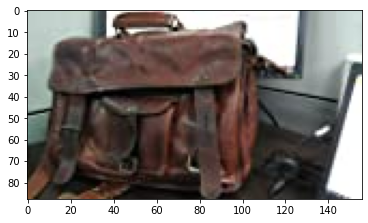

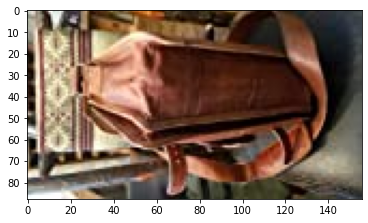

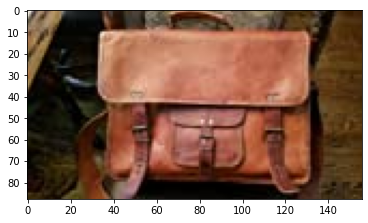

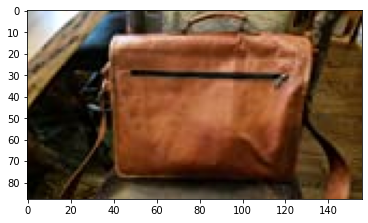

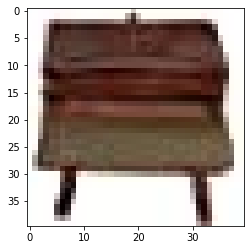

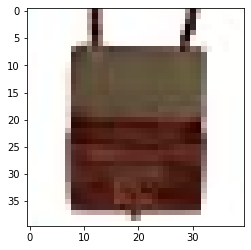

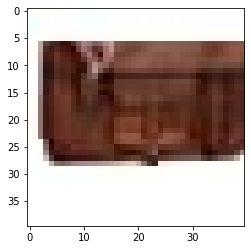

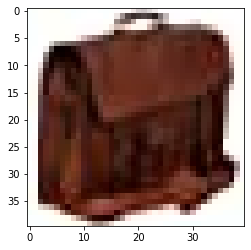

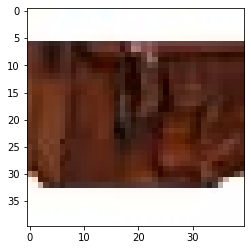

In [42]:
# Plotting multiple images for object B004WB8EYM
obj_image = df_model.loc[df_model.asin == 'B00FR0JMNE'].reset_index(drop = True)
#print(obj_image)
# Ensuring links are different 
print(obj_image.image.values)
print("Category of the image is: ", obj_image['category'].loc[0])
i = 0
for i in range(9):
    plt.figure()
    show_image_from_url(obj_image['image'].loc[i])

### Some problems with using just review data - review images for camera is people putting in random "clicked" photos

In [43]:
# Ploting multiple review images of same object
counts = new_df1.asin.value_counts()
counts

B00I8BICCG    271
B00U2W4JEY    238
B005MTMFHU    233
B00DIF2BO2    220
B001S2PPT0    202
             ... 
B00PLMYE5E      1
B017QROB4U      1
B002XQ3C0E      1
B005XUE9WC      1
B00GOA3VME      1
Name: asin, Length: 24735, dtype: int64

In [47]:
### THIS PART SHOWS THE PROBLEMS WITH SOME PRODUCTS - SUCH AS CAMERA PHOTOS BEING RANDOMLY TAKEN PHOTOS
# Plotting images for object B00007E7JU
obj_image = new_df1.loc[new_df1.asin == 'B00I8BICCG'].reset_index(drop = True)
#print(obj_image)
print("Category of the image is: ", df.loc[df.asin == 'B00I8BICCG']['category'].head(1).values)
for i in range(5):
    plt.figure()
    #print(obj_image['image'].values)
    show_image_from_url(obj_image['image'].loc[random.randint(0,len(obj_image)-1)])

Category of the image is:  ["['Electronics', 'Camera & Photo', 'Lenses', 'Camera Lenses', 'SLR Camera Lenses']"]


ValueError: empty range for randrange() (0,0, 0)

<Figure size 432x288 with 0 Axes>

### Getting arrays for images out

In [19]:
#create function to obtain image data and convert into generator
def get_image_data(img_url):
    #url_list = url_list.replace('\'','').replace('[','').replace(']','').split(',')
    #img_list = []
    #print(len(url_list))
    try:
    #Download from image url and import it as a numpy array
        response = urllib.request.urlopen(img_url)
        image = np.asarray(bytearray(response.read()), dtype="uint8")
    #print(1)
    #print(image.shape)
    #Read the numpy arrays as color images in OpenCV
        image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
    #image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    #print(image_bgr.shape)
    #Resize the image to 35x35x3 pixels size - review images are much bigger -> but they have been converted as well 
        if image.shape[0]> 1000:
            image = cv2.resize(image_bgr, (35, 35))
        else:
            image = np.nan
    #img_list.append(image)
        return (img_url,image)
    except:
        return None

In [ ]:
%%time
# Cleaning garbage values
gc.collect()

#print(df_model.shape)
df_model = df_model.dropna(how = 'any')
#print(df_model.shape)
n_loops = len(df_model)//10000
print(n_loops)
len_df = len(df_model)
append_df = pd.DataFrame(columns = ['image','loaded_img'])

for i in range(n_loops+1):
# Applying Image generator
    if i * 10000 + 10000 < len(df_model):
        urls = df_model[i*10000:i*10000+10000].image.values
        #print(len(urls))
        result = pd.DataFrame(Pool(10).map(get_image_data, urls), columns = ['image','loaded_img'])
        append_df = append_df.append(result, True)
    else:
        urls = df_model[i*10000:len_df+1].image.values
        result = pd.DataFrame(Pool(10).map(get_image_data, urls), columns = ['image','loaded_img'])
        append_df = append_df.append(result, True)   
    print(i, "Complete!")   

#print(append_df)
df_model_final = df_model.merge(append_df, how = 'left', on = 'image')
df_model_final = df_model_final.dropna(how = 'any')
df_model_final.shape
df_model_final.to_csv("Model_Input_data_35x35_14tags.csv", index = False)

In [ ]:
df_input = df_model_final
df_input.drop(columns = ['asin','category','image'], axis = 1, inplace = True)
df_input.columns.values

### Building model - Vanilla

In [ ]:
# Inspiration for this architecture: VGG neural network

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(35,35, 3), padding = 'same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(tags.shape[1], activation='sigmoid')) # output layer = number of tags

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr = 0.0005),
              metrics=['accuracy'])

# checkpoint
filepath="model_best_vanilla.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
dataset = df_input[['loaded_img']]
y = df_input.drop('loaded_img',axis = 1)
# Randomly splitting onto train-test datasets
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train = np.array(X_train.loaded_img.tolist())
X_val = np.array(X_val.loaded_img.tolist())

In [ ]:
#n = len(df_input) #Size of data
#X_train = np.array(df_input.loaded_img.tolist())
model.fit(X_train, y_train,        # Training data
          batch_size=512,          # Batch size 
          epochs=250,               # Epochs to train for
          verbose=1,               # Displaying progress
          validation_data=(X_val,y_val),    # 10% validation split for checking movement on validation data
          callbacks=callbacks_list # This parameter ensures that the model weights are saved whenever validation loss decreases
         )

### Testing Model - Vanilla

In [ ]:
# Load best model
model = load_model('/kaggle/working/model_best_vanilla.hdf5')
print("Model load complete!")

X_test_array = np.array(X_test.loaded_img.tolist())
prediction_train = model.predict(X_train)
prediction_val = model.predict(X_val)
prediction_test = model.predict(X_test_array)

#labels
labels_train = (prediction_train > 0.5).astype(np.int)
labels_val = (prediction_val > 0.5).astype(np.int)
labels_test = (prediction_test > 0.5).astype(np.int)

print("Accuracy of train tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_train), labels_train)*100)
print("Accuracy of validation tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_val), labels_val)*100)
print("Accuracy of test tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_test), labels_test)*100)
print("The accuracy numbers are subset accuracy! i.e a sample is correct only if ALL the classes are predicted correctly!")
print("We are going to use Hemming Score to judge the model.")

### Calculating Hamming Score for data

In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    https://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

labels_train = (prediction_train > 0.5).astype(np.int)
labels_val = (prediction_val > 0.5).astype(np.int)
labels_test = (prediction_test > 0.5).astype(np.int)

print("The Hamming score is the ratio of [intersection of 1's]/[union of 1's]; where intersection and union is between predicted and true data.")
print("Hamming score of train tags (at 0.5 threshold) are: ", hamming_score(np.array(y_train), labels_train))
print("Hamming score of validation tags (at 0.5 threshold) are: ", hamming_score(np.array(y_val), labels_val))
print("Hamming score of test tags (at 0.5 threshold) are: ", hamming_score(np.array(y_test), labels_test))

In [ ]:
seq = np.arange(0.05, 0.95, 0.025)

for i in seq:
    labels_val = (prediction_val > i).astype(np.int)
    score = hamming_score(np.array(y_val), labels_val)
    print("Threshold: ",i , " Score: ", score)

## For vanilla model, we get the best Hamming Score (33.43) at threshold of 0.225

In [ ]:
# Selecting best threshold from above
labels_test = (prediction_test > 0.225).astype(np.int)

print("Accuracy of test tags (at best threshold) are: ", accuracy_score(np.array(y_test), labels_test)*100)
print("Hamming score of test tags (at best threshold) are: ", hamming_score(np.array(y_test), labels_test))

In [ ]:
# Below are the count of tags identified
print("The predicted test tags data looks as follows:")
print(">0: ",len(np.where(np.sum(labels_test, axis = 1)>0)[0]))
print(">1: ",len(np.where(np.sum(labels_test, axis = 1)>1)[0]))
print(">2: ",len(np.where(np.sum(labels_test, axis = 1)>2)[0]))
print(">3: ",len(np.where(np.sum(labels_test, axis = 1)>3)[0]))

print("The actual test data looks as follows:")
print(">0: ",len(np.where(np.sum(np.array(y_test), axis = 1)>0)[0]))
print(">1: ",len(np.where(np.sum(np.array(y_test), axis = 1)>1)[0]))
print(">2: ",len(np.where(np.sum(np.array(y_test), axis = 1)>2)[0]))
print(">3: ",len(np.where(np.sum(np.array(y_test), axis = 1)>3)[0]))

### Building model - Pre-trained: VGG16

In [ ]:
#model = Sequential()
densenn = VGG16(include_top = False, weights='imagenet',input_shape = (35,35,3))

output = densenn.layers[-1].output
#output = Flatten()(output)
dense_model = Model(densenn.input, output)

# Setting the model to be non-trainable
dense_model.trainable = False
for layer in dense_model.layers:
    layer.trainable = False
    
# Checking to ensure the same
layers = [(layer, layer.name, layer.trainable) for layer in dense_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

In [ ]:
model = Sequential()
model.add(dense_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(tags.shape[1], activation='sigmoid')) # output layer = number of tags
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr = 0.0005),
              metrics=['accuracy'])

# checkpoint
filepath="model_best_pretrained.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
dataset = df_input[['loaded_img']]
y = df_input.drop('loaded_img',axis = 1)
# Randomly splitting onto train-test datasets
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train = np.array(X_train.loaded_img.tolist())
X_val = np.array(X_val.loaded_img.tolist())

In [ ]:
#n = len(df_input) #Size of data
#X_train = np.array(df_input.loaded_img.tolist())
model.fit(X_train, y_train,        # Training data
          batch_size=512,          # Batch size 
          epochs=75,               # Epochs to train for
          verbose=1,               # Displaying progress
          validation_data=(X_val,y_val),    # 10% validation split for checking movement on validation data
          callbacks=callbacks_list # This parameter ensures that the model weights are saved whenever validation loss decreases
         )

### Testing Model - Pre-trained

In [ ]:
# Load best model
model = load_model('/kaggle/working/model_best_pretrained.hdf5')
print("Model load complete!")

X_test_array = np.array(X_test.loaded_img.tolist())
prediction_train = model.predict(X_train)
prediction_val = model.predict(X_val)
prediction_test = model.predict(X_test_array)

#labels
labels_train = (prediction_train > 0.5).astype(np.int)
labels_val = (prediction_val > 0.5).astype(np.int)
labels_test = (prediction_test > 0.5).astype(np.int)

print("Accuracy of train tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_train), labels_train)*100)
print("Accuracy of validation tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_val), labels_val)*100)
print("Accuracy of test tags (at 0.5 threshold) are: ", accuracy_score(np.array(y_test), labels_test)*100)
print("The accuracy numbers are subset accuracy! i.e a sample is correct only if ALL the classes are predicted correctly!")
print("We are going to use Hemming Score to judge the model.")

### Calculating Hamming Score for data

In [ ]:
labels_train = (prediction_train > 0.5).astype(np.int)
labels_val = (prediction_val > 0.5).astype(np.int)
labels_test = (prediction_test > 0.5).astype(np.int)

print("The Hamming score is the ratio of [intersection of 1's]/[union of 1's]; where intersection and union is between predicted and true data.")
print("Hamming score of train tags (at 0.5 threshold) are: ", hamming_score(np.array(y_train), labels_train))
print("Hamming score of validation tags (at 0.5 threshold) are: ", hamming_score(np.array(y_val), labels_val))
print("Hamming score of test tags (at 0.5 threshold) are: ", hamming_score(np.array(y_test), labels_test))

In [ ]:
seq = np.arange(0.05, 0.95, 0.025)

for i in seq:
    labels_val = (prediction_val > i).astype(np.int)
    score = hamming_score(np.array(y_val), labels_val)
    print("Threshold: ",i , " Score: ", score)

## We get the best Hamming Score (17.33) at threshold of 0.05

In [ ]:
# Selecting best threshold from above
labels_test = (prediction_test > 0.05).astype(np.int)

print("Accuracy of test tags (at best threshold) are: ", accuracy_score(np.array(y_test), labels_test)*100)
print("Hamming score of test tags (at best threshold) are: ", hamming_score(np.array(y_test), labels_test))

In [ ]:
# Below are the count of tags identified
print("The predicted test tags data looks as follows:")
print(">0: ",len(np.where(np.sum(labels_test, axis = 1)>0)[0]))
print(">1: ",len(np.where(np.sum(labels_test, axis = 1)>1)[0]))
print(">2: ",len(np.where(np.sum(labels_test, axis = 1)>2)[0]))
print(">3: ",len(np.where(np.sum(labels_test, axis = 1)>3)[0]))

print("The actual test data looks as follows:")
print(">0: ",len(np.where(np.sum(np.array(y_test), axis = 1)>0)[0]))
print(">1: ",len(np.where(np.sum(np.array(y_test), axis = 1)>1)[0]))
print(">2: ",len(np.where(np.sum(np.array(y_test), axis = 1)>2)[0]))
print(">3: ",len(np.where(np.sum(np.array(y_test), axis = 1)>3)[0]))

## Tagging System

In [ ]:

#!cp data_labels.csv "drive/My Drive/"

In [ ]:
#df_model_final.to_csv("Model_Input_data_35x35.csv")